# 1. Business Objectives

<b>Overall objective</b>

- Our overall objective is to build a production-quality movie recommendation pipeline, in order to `provide personalizied TOP-10 list of movies specific to our users`. 
- These recommended movies will be displayed in the section of `TOP 10 MOVIES THAT YOU MAY LIKE` in the carousel on the APP or website. 
- The goal of this new pipeline is to increase the chance of users clicking into, watching and liking one of the recommended movies, thus improving user retention and activeness on our APP.


<b>Target Users</b>

- This pipeline will mainly target at `active users`, i.e., those with more than 20 ratings, to alleviate the cold start problem. 
- In the future, differnet pipelines, such as user survey, may be developed for movie recommendation for cold start users.


<b>Sampling methods</b>

- To improve recommendation accuracy, we use `Random Sampling after Minimum Requirement(RSMR)` to sample from the full MovieLens dataset, i.e., sample from the subset with cold users and movies excluded. 
- The final sample includes 1,170,000+ ratings applied to `1,000 movies` by `20,000 users`


<b>Critical metrics that we look to optimize</b>
- Most attention will be paid to improve the recommendation pipeline's performance on metrics like `recall@10` , `user coverage`: the higher these metrics are, the better job we are doing in making well recommendations to our active users. 

- We will also look at ranking accuracy metrics like `NDCG`, coverage metrics like `movie coverage`, `catalog coverage`, and how well our pipeline performs on different user groups of different rating levels (`recall over users`).

- Tradeoffs we are willing to make: since our overal objective is to make good recommendation to users, we will care less on metrics like `movie-coverage`, `catalog-coverage` and `recall over movies`


<b>Performance Requirements</b>

- The system should be scalable with the selected dataset. Training time and testing time should be less than a certain level to allow for a daily-based update.


<b>Recommendation Pipeline Architectures</b>


![jupyter](./figure1.png)

# 2. Data Exploration and Sampling

In [5]:
# basic packages
import pandas as pd
import numpy as np
import math
import time
from collections import defaultdict,OrderedDict
from scipy import sparse
np.warnings.filterwarnings('ignore')

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KDTree

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# self-build modules
from model.bias_model import *
from model.ann_kdtree import *
from model.mf_nn import *
from model.ann_nn import *
from model.helper import *

### 1.1 Load & Understand the Full Dataset

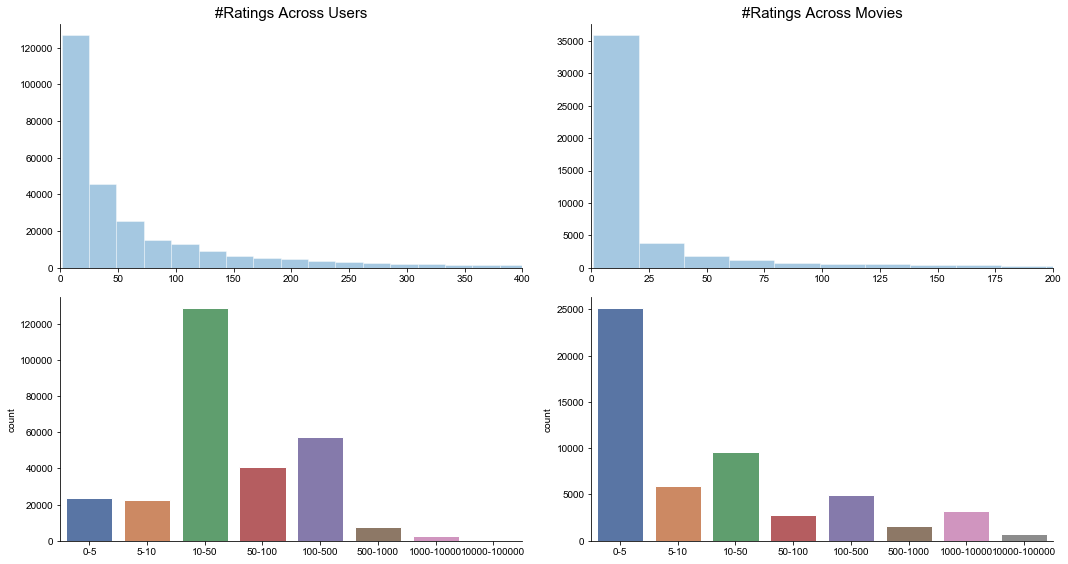

In [6]:
df = pd.read_csv('./ml-latest/ratings.csv')
df_tag = pd.read_csv('./ml-latest/genome-scores.csv')

#describe full rating dataset
user_freq, movie_freq = describe(df)
user_grouped = group(df, to_group = 'user')
user_cnt = user_grouped.groupby(['groupId', 'groupRange']).count().rename(columns={"userId":"count"}).reset_index()
movie_grouped = group(df, to_group = 'movie')
movie_cnt = movie_grouped.groupby(['groupId', 'groupRange']).count().rename(columns={"movieId":"count"}).reset_index()
plot_df(user_freq, movie_freq, user_cnt, movie_cnt, user_grouped, movie_grouped)

### 1.2 Sampling & Train Test Spliting

`User and Movie threshold`: from above, a majority of users have rated more than 10-20 movies in our dataset, so we decide to focus on recommendating to these `active users (>20 ratings)` at this stage, to improve recommending recall and alleviate the cold start problem. Similar threshold was applied to movie as well to alleviate this problem. 


We then do a random sample to obtain a subset of the data, which contains `1,170,000+ ratings` applied to `1,000 movies` by `20,000 users`

number of users: 20000
number of items: 1000
number of ratings: 1179969


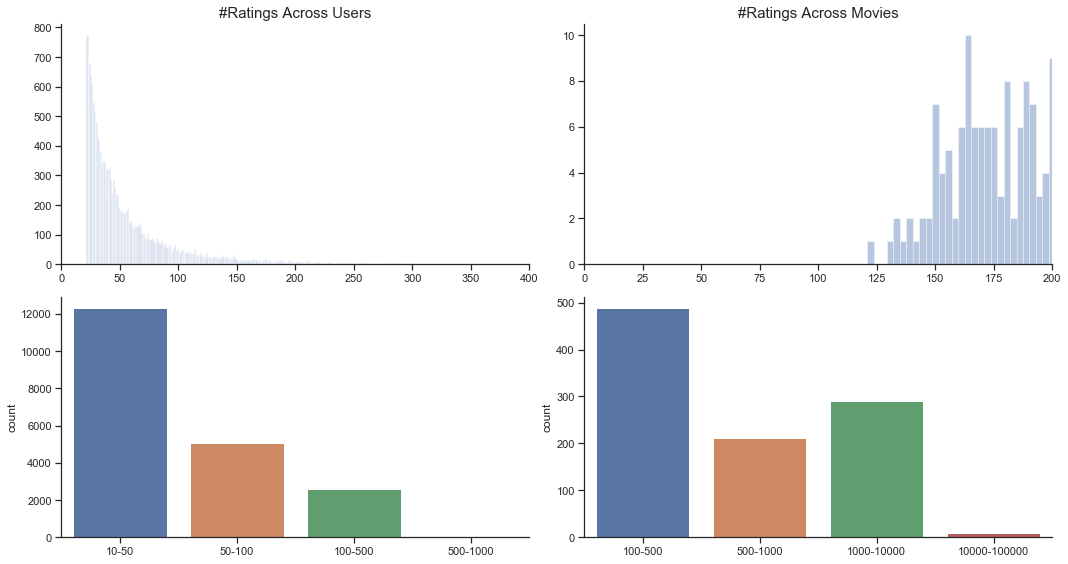

In [7]:
df_sample = sample_df(df)

#describe sample dataset
user_freq_sample, movie_freq_sample = describe(df_sample)
user_grouped_sample = group(df_sample, to_group = 'user')
user_cnt_sample = user_grouped_sample.groupby(['groupId', 'groupRange']).count().rename(columns={"userId":"count"}).reset_index()
movie_grouped_sample = group(df_sample, to_group = 'movie')
movie_cnt_sample = movie_grouped_sample.groupby(['groupId', 'groupRange']).count().rename(columns={"movieId":"count"}).reset_index()
plot_df(user_freq_sample, movie_freq_sample, user_cnt_sample, movie_cnt_sample, user_grouped_sample, movie_grouped_sample)

#### Train Test Split

For each user, use the latest 20% ratings as testing set and oldest 80% as training set. to emulate the real-world movie-recommendating business setting.

In [8]:
train_df, test_df = train_test_split_by_time(df_sample)
print(len(train_df))
print(len(test_df))

rating_train = train_df.pivot(index='movieId', columns='userId', values='rating')
rating_test = test_df.pivot(index='movieId', columns='userId', values='rating')
print(rating_train.shape)
print(rating_test.shape)

952005
227964
(1000, 20000)
(1000, 20000)


# 3. Baseline Model for Benchmarks

For part 3, two baseline models are built for benchmarking. One is `Bias Model`, another one is `Matrix Factorization Model(CF)`

### 3.1 Baseline Model 1: Bias Model

In [6]:
#model initializing
model_bias = bias_model() 

#training
start = time.time()    
model_bias.fit(train_df)
end = time.time()
train_time = end - start

#testing
start = time.time()
rating_pred_bias = model_bias.pred(test_df)
end = time.time()
test_time = end - start
print("train_time: ", train_time)
print("test_time: ", test_time)

train_time:  0.7887649536132812
test_time:  0.38976287841796875


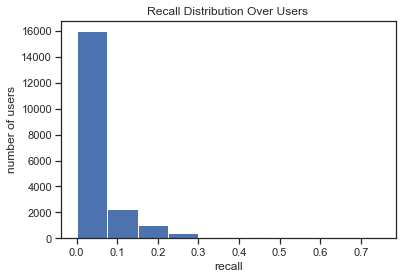

Mean Recall: 0.032
Recall for each user group:  {'10-50': 0.01, '50-100': 0.0126, '100-500': 0.0195, '500-1000': 0.0}


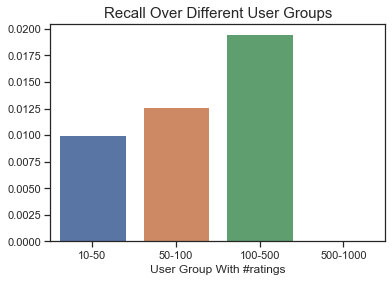

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.201
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.033
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.033

NDCG: 0.328


In [7]:
# Evaluation

k_items = 10
rating_pred = rating_pred_bias

#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

The bias model basically use movie mean rating plus user mean rating as predicted ratings, and we will recommend top 10 movies that are not seen yet to users.

Most users rated less than 50 movies in train set, and even less on test set. This means it will be inevitably difficult to predict what ther users will rate as Top 10 among the 900+ movies that are not rated yet by the users. So we accept a relatively low mean recall@10. 

The recall@10 rate of the bias baseline model is `3.2%`, and the fraction of users for which at least 1 movie can be recommended well is `20.1%`, with a NDCG score of `0.328`. This means we can recommend at least 1 movie well to about 1/5 of our active users. 

However, this bias model performs very bad (recall almost to zero) in the most active user groups (rated more 500 movies). This might be caused by that the mechanism of the bias model to take average of user ratings would average out user preferences, which make it difficult to predict well and recommend well to them. 

This is undesireble. Using other stronger algorithms might predict better with this user group.

### 3.2 Baseline Model 2: MF Model

The next baseline Model we build is Model-based Collaborative Filtering Model, using Matrix Factorization powered by PySpark.

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

In [6]:
#initialize spark 
spark = SparkSession.builder.appName("PySpark ALS Model").getOrCreate() 
train = spark.createDataFrame(train_df)  
test = spark.createDataFrame(test_df)  

In [7]:
#build model

#We acheive the max average recall of 0.044 with cross validation, by setting max_iter=25, regParam = 0.1, rank=10.
als = ALS(maxIter=25, regParam=0.1, rank=10, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

#training
start = time.time()    
model_mf = als.fit(train)
end = time.time()
train_time = end - start 

#testing 
start = time.time()
predictions = model_mf.transform(test)
rating_pred_mf = get_rating_pred(model_mf, predictions, rating_train)
end = time.time()
test_time = end - start

print("train_time: ", train_time)
print("test_time: ", test_time)

train_time:  32.672394037246704
test_time:  27.65398406982422


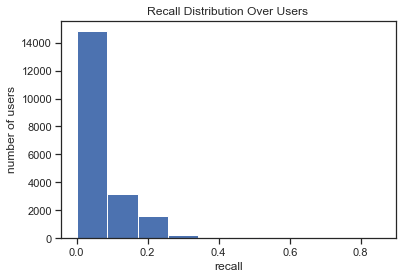

Mean Recall: 0.044
Recall for each user group:  {'10-50': 0.0264, '50-100': 0.0292, '100-500': 0.0349, '500-1000': 0.1333}


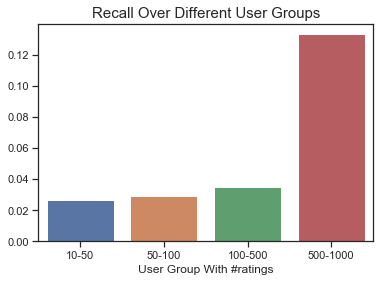

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.259
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.296
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.296

NDCG: 0.349


In [8]:
# Evaluation

k_items = 10
rating_pred = rating_pred_mf

#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

The MF baseline model performs better in all metrics: `recall@10 = 4.4%`, `user coverage = 25.9%`, `NDCG = 0.349`, `movie coverage = 29.6%`.

The mean recall also increases as the ratings of users increase. Especially, it has a relatively high recall on the most active users (`recall = 0.12`). This indicates that MF model tend to work well for the active users with a great number of ratings, the density of which help the model figure out the latent features well.

# 4. ANN Model

For part 4, we will explore another efficient algorithm, `Approximate Nearest Neighbors (ANN)`, using user and movie embeddings genereated by the MF model. Since both users and movies are embedded in the same dimension space, we only need to find the nearest 10 movies from the user that are not rated by the user yet. 

In [11]:
#model initializing

#We acheive the max average recall of 0.053 with cross validation, by setting max_iter=5, rank=20, leaf_size=50.
k_items = 10
max_iter = 5
rank = 20
leaf_size = 50

#training
start = time.time()  
model_ann = ann_kdtree(max_iter=max_iter, regparam=0.1, rank=rank, leaf_size=leaf_size, k_items=k_items)
model_ann.fit(train_df)
end = time.time()  
train_time = end - start

#testing
start = time.time()  
rating_pred_ann =  model_ann.pred(test_df)
end = time.time() 
test_time = end - start 

print("train_time: ", train_time)
print("test_time: ", test_time)

training begins ......
Begin to retrieve latent features from cf ......
training finishes.
prediction begins ......
prediciton finishes.
train_time:  49.69563293457031
test_time:  24.325652837753296


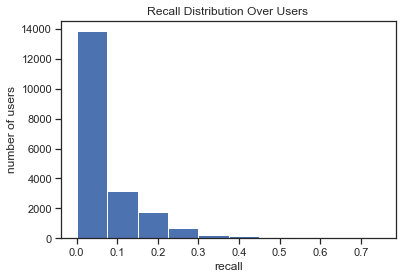

Mean Recall: 0.053
Recall for each user group:  {'10-50': 0.032, '50-100': 0.0355, '100-500': 0.0357, '500-1000': 0.0667}


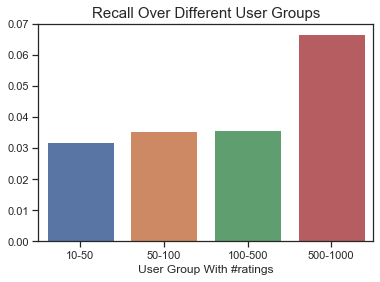

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.307
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.444
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.444

NDCG: 0.324


In [12]:
#evaluation

k_items = 10
rating_pred = rating_pred_ann

#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

The ANN model further improves performances in most metrics: `recall@10 = 5.3%`, `user coverage = 30.7%`, `NDCG = 0.324`, `movie coverage = 44.4%`.

ANN model also predicts better as ratings of movie increase for each user group. Although `recall(0.07)` for the most active user group is lower than `MF model(0.13)`, it performs  better for the majority group (group 10-50, 50-100, 100-500).

# 5. Hybrid Model Exploration 

For part 5, we will try combinations of different algorithms, such as MF, ANN, NN etc, to develop a stronger hybrid pipeline model.

The hope is that introducing more complicated structures like NN in reranking stage will help improve recommendation metrics(recall@10).

## 5.1 MF-NN Model

Algorithms deployed:

- Preranking stage: MF 
- Reranking stage: NN

### 5.1.1 MF-NN Model (MF embedding)

In [9]:
#model initializing
tuned_model_mfnn = mf_nn(max_iter = 15, regparam = 0.1, k = 30, rank = 10, movie_tag_embed=False) 

#training
start = time.time()    
tuned_model_mfnn.fit(train_df, df_tag)
end = time.time()
train_time = end - start

#testing
start = time.time()
rating_pred_mfnn = tuned_model_mfnn.pred(test_df)

end = time.time()
test_time = end - start
print("train_time: ", train_time)
print("test_time: ", test_time)

Training begins.......
training set created
start training neural network......
model training finished
creating testing set for neural network.....
prediction finished
train_time:  398.08773398399353
test_time:  50.552711963653564


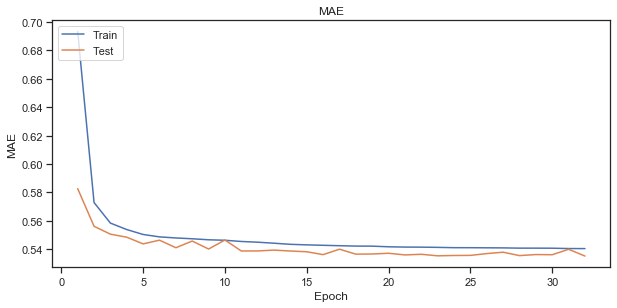

In [10]:
plot_history(tuned_model_mfnn.history)

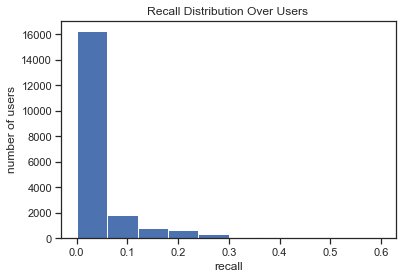

Mean Recall: 0.029
Recall for each user group:  {'10-50': 0.0178, '50-100': 0.0203, '100-500': 0.0205, '500-1000': 0.0667}


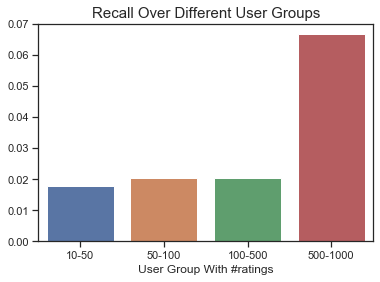

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.188
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.353
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.353

NDCG: 0.310


In [11]:
# Evaluation

k_items = 10
rating_pred = pd.DataFrame(index = rating_test.index, columns = ['dummy']).join(rating_pred_mfnn.pivot(index='movieId', columns='userId', values='rating'), how = 'left').drop('dummy', axis = 1)


#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

As the result shows, using MF-NN hybrid model fails to beat the single MF model in terms of `recall@10`, `user coverage` and `NDCG`. The only improvement is `movie coverage`, increasing from `29.6%` to `35.3%`. It also takes more time to train, which is not worth the time clearly.

### 5.1.2 MF-NN Model (MF embedding + movie tag embedding)

We try to add in some side information like movie tag relevance. So we process it into a 1128-dimension tag embeddings for each movie, and feed them into the Neural Netwerok as well, to see if it can further improve the resutls.

In [8]:
#model initializing
tuned_model_mfnn = mf_nn(max_iter = 15, regparam = 0.1, k = 30, rank = 10, movie_tag_embed=True) 

#training
start = time.time()    
tuned_model_mfnn.fit(train_df, df_tag)
end = time.time()
train_time = end - start

#testing
start = time.time()
rating_pred_mfnn = tuned_model_mfnn.pred(test_df)

end = time.time()
test_time = end - start
print("train_time: ", train_time)
print("test_time: ", test_time)

Training begins.......
training set created
start training neural network......
model training finished
creating testing set for neural network.....
prediction finished
train_time:  699.2198009490967
test_time:  128.2756917476654


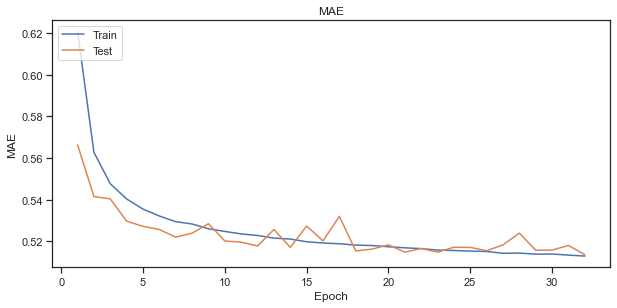

In [9]:
plot_history(tuned_model_mfnn.history)

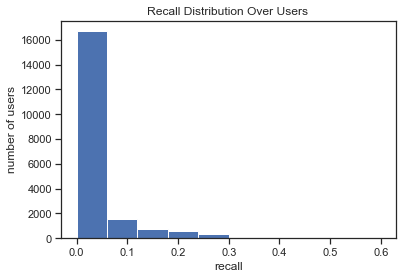

Mean Recall: 0.025
Recall for each user group:  {'10-50': 0.016, '50-100': 0.0184, '100-500': 0.0215, '500-1000': 0.0}


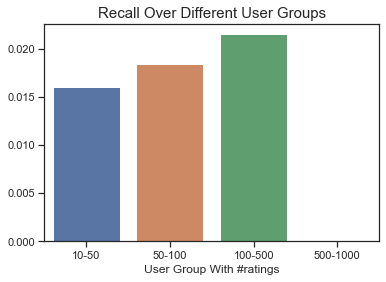

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.166
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.307
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.307

NDCG: 0.309


In [10]:
# Evaluation

k_items = 10
rating_pred = pd.DataFrame(index = rating_test.index, columns = ['dummy']).join(rating_pred_mfnn.pivot(index='movieId', columns='userId', values='rating'), how = 'left').drop('dummy', axis = 1)


#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

As the result shows, adding in side information of movie tag relavance fails to boost performances in all metrics. And it performs very poor for the most active user groups, perhaps it has also introduced noises and could not fit well into this pipeline.

## 5.2 ANN-NN Model

Algorithms deployed:

- Preranking stage: ANN (kd-tree based)
- Reranking stage: NN

### 5.2.1 ANN-NN Model (MF embedding)

In [15]:
#model initializing

k_items=10
#training
start = time.time()  
model_ann_nn = ann_nn(max_iter=2, regparam=0.1, prerank_k=20, leaf_size=30, rank=20, 
                      batch_size=256, epochs=50, k_items=k_items, verbose = 0, use_element_embed=False)
model_ann_nn.fit(train_df, df_tag)
end = time.time()  
train_time = end - start

#testing
start = time.time()  
df_pred =  model_ann_nn.pred(test_df)
end = time.time() 
test_time = end - start 

print("train_time: ", train_time)
print("test_time: ", test_time)

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399930, 4)
shape of features array in test set: (399930, 40)
shape of target array in test set: (399930,)
train_time:  400.2902810573578
test_time:  40.054936170578


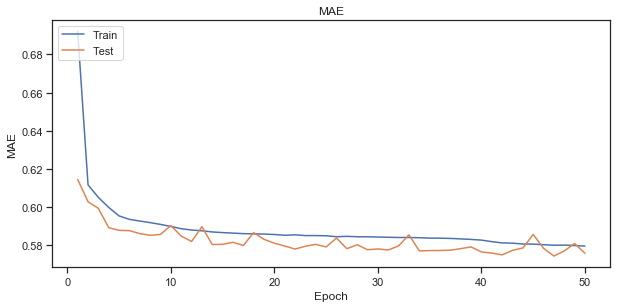

In [17]:
plot_history(model_ann_nn.history)

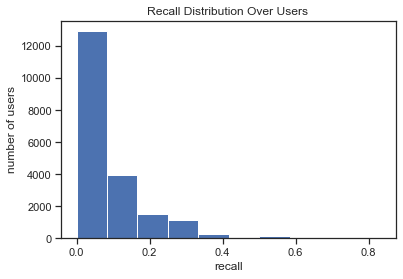

Mean Recall: 0.065
Recall for each user group:  {'10-50': 0.0412, '50-100': 0.0439, '100-500': 0.0449, '500-1000': 0.0667}


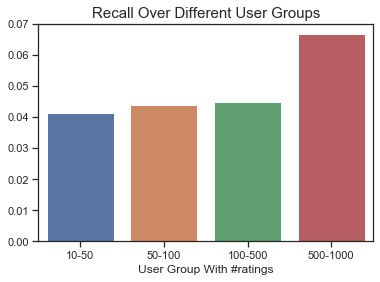

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.354
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.311
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.311

NDCG: 0.339


In [16]:
# Evaluation

k_items = 10
rating_pred = pd.DataFrame(index = rating_test.index, columns = ['dummy']).join(df_pred.pivot(index='movieId', columns='userId', values='rating'), how = 'left').drop('dummy', axis = 1)

#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

As the result shows, using ANN-NN hybrid model performs the best in all key metrics so far: `recall@10 = 6.5%`, `user coverage = 35.4%`, `NDCG = 0.339`.

It also predicts better as ratings of movie increase for each user group. 


Although movie coverage is a bit lower than the single ANN model, it performs quite well in mean recall@10 for all user groups (no less than 0.04).
 
 
The complexity introduced and more time taken to train could indeed result in improvement in mean recall@10, which is worth the efforts.

### 5.2.1 ANN-NN Model (MF embedding + movie tag embedding)

In [5]:
#model initializing

k_items=10
#training
start = time.time()  
model_ann_nn = ann_nn(max_iter=2, regparam=0.1, prerank_k=20, leaf_size=30, rank=20, 
                      batch_size=256, epochs=32, k_items=k_items, verbose = 0, use_element_embed=True)
model_ann_nn.fit(train_df, df_tag)
end = time.time()  
train_time = end - start

#testing
start = time.time()  
df_pred =  model_ann_nn.pred(test_df)
end = time.time() 
test_time = end - start 

print("train_time: ", train_time)
print("test_time: ", test_time)

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 1168)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399876, 4)
shape of features array in test set: (399876, 1168)
shape of target array in test set: (399876,)
train_time:  1185.3029670715332
test_time:  78.87011003494263


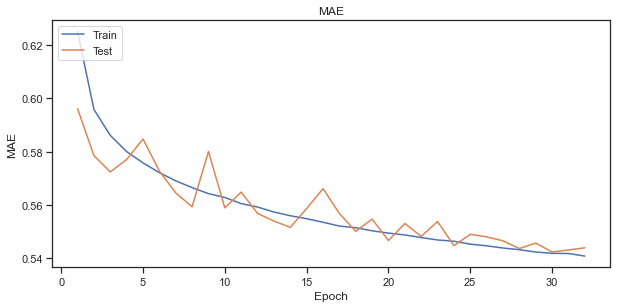

In [6]:
plot_history(model_ann_nn.history)

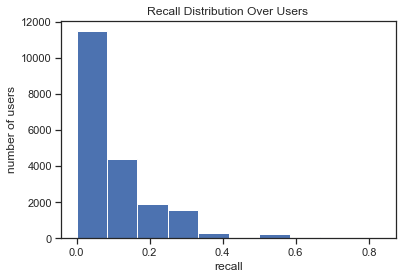

Mean Recall: 0.082
Recall for each user group:  {'10-50': 0.056, '50-100': 0.0583, '100-500': 0.0595, '500-1000': 0.0667}


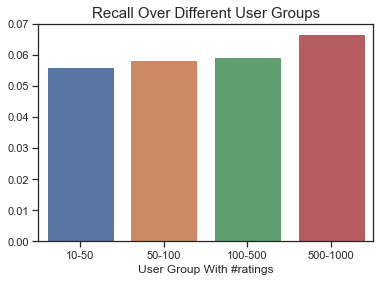

User coverage:  the fraction of users for which at least 1 items can be recommended well is 0.427
Item coverage: the fraction of items that can be recommended to at least 1 users well is 0.350
Catalog coverage: the fraction of items that are in the top-10 for at least 1 user is 0.350

NDCG: 0.356


In [7]:
# Evaluation

k_items = 10
rating_pred = pd.DataFrame(index = rating_test.index, columns = ['dummy']).join(df_pred.pivot(index='movieId', columns='userId', values='rating'), how = 'left').drop('dummy', axis = 1)

#recall
user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items)
print(f"Mean Recall: {avg_recall:.3f}")
user_grouped = group(train_df, 'user')
recall_dict = recall_over_user_group(rating_test, rating_pred, user_grouped=user_grouped, k_items=k_items)

#coverage
user_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type='user')
movie_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'item')
catalog_cov = cal_coverage(rating_test, rating_pred, k_items=k_items, threshold=1, coverage_type = 'catalog')

#ndcg
ndcg_score = ndcg(rating_test, rating_pred)
print()
print(f"NDCG: {ndcg_score:.3f}")

<b>Result Interpretation</b>: 

Adding in side information of movie tag relavance DID boost performances in all key metrics. It achieves the best result so far:
`recall@10 = 8.2%`, `user coverage=42.7%`, `NDCG=0.356`.

And it achieves good recall score on all user groups (no less than 5%) 

This indicates that adding side information upon the simple algorithm like ANN, could indeed help improve model' ability to predict well in the re-ranking stage. 

# 5. Conclusion

<b>Our Goal</b>

- Our overall objective is to build a production-quality movie recommendation pipeline, in order to `provide personalizied TOP-10 list of movies specific to our users`.

<b>What We Have Explored</b>

- We have explored and tuned different single and hybrid models. For benchmarking, we built 2 baseline models - `Bias Model`, `Matrix Factorization Model(MF)`. 

- Built upon movie and user embedding generated by MF, we also explored another efficient algorithm - `KDTree-based Approximate Nearest Neighbor(ANN)`. 

- To empower our prediction of ranking with stronger algorithms, we built 2 hybrid models - `MF-NN model` and `ANN-NN model`. This combination of models allow an efficient model to find the approximate TOP K first, and then use a stronger model like Neural Network to finally choose TOP 10 out of it. 

- For the `Neural Network(NN)` model, we mainly fed into it the `user-movie embeddings` generated by MF model. And we also introduced side information like `tag relevance embedding` to further improve its potential to predict the ratings well.


<b>Final Recommendation</b>

- To decide whether to launch these models, we evaluated their performances on our key metrics - `recall@10`, `user coverage@1` and `scalability`. The results of each model explored are demonstrated in the table below.

- `ANN-NN Model with MF & Tag embedding` performs the best in both recall@10 and user coverage@1. These two results mean that the recommendation system would recommend at least 1 movie well to `42.7%` percent of active users, and would recommend the true TOP 10 rated movies for `8.2%`of the time. The NDCG score also ranks the highest. And the training time and test time is within the acceptable range, which takes about 20 minutes to train and 1 minute to predict. This would be sufficient for a daily update. 

- With this result, we would recommend the technical manager to move forward with the `ANN-NN Model with MF & Tag embedding` for AB testing and launching.

<b>Watchouts and Future Exploration</b>

- We are also aware that as number of target users or the update frequency requirement increases, we may need to test using other more efficient models like `Scalable Nearest Neighbor(ScaNN)` to scale with large datasets. 

- Other things we could explore include using other sophisticated models like FM structures and different features like movie genres and movie description text.





![jupyter](./result1.png)
